# Project Block 2: Advanced Statistics
## Part 2 - Forecasting Queretaro industrial activity
Fabián González Vera A01367585

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statistics as st


## ARIMA(p,d,q)SARIMA(P,D,Q,#p)
---

<Axes: xlabel='Periodos'>

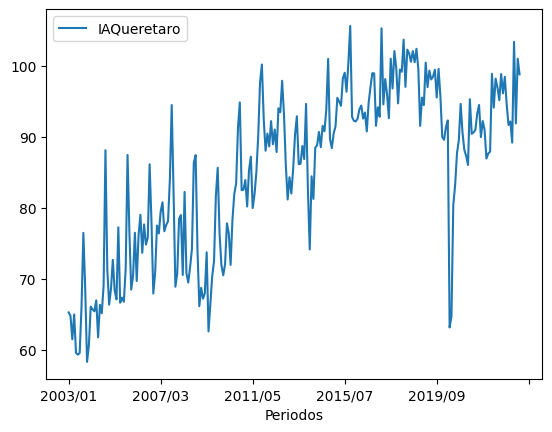

In [260]:
IAQ = pd.read_csv('Indicadores20231012110325.csv')
IAQ=IAQ.set_index(['Periodos'])
IAQ.plot()

In [261]:
IAQ

,IAQueretaro
Periodos,
2003/01,65.234491
2003/02,64.750420
2003/03,61.444991
2003/04,64.953065
2003/05,59.522348
...,...
2023/02,89.168194
2023/03,103.384331
2023/04,91.876916


(NULL) H0: |φ_1| = 1  => La serie es No Estacionaria <br>
(ALT)  H1: |φ| < 1   => Es Estacionaria

In [262]:
from statsmodels.tsa.stattools import adfuller
print(adfuller(IAQ['IAQueretaro'])[1])
#pvalue 

0.3552197579633277


The pvalue returned by the Dickey-Fuller test is 0.3552197579633277 and is greater than 0.05.

In [263]:
IAQ['lIndAct'] = np.log(IAQ['IAQueretaro'])
IAQ['diff1'] = IAQ['lIndAct'] - IAQ['lIndAct'].shift(1)
# log - log shift 12
IAQ['diff12'] = IAQ['lIndAct'] - IAQ['lIndAct'].shift(12)
IAQ

,IAQueretaro,lIndAct,diff1,diff12
Periodos,,,,
2003/01,65.234491,4.177988,NaN,NaN
2003/02,64.750420,4.170540,-0.007448,NaN
2003/03,61.444991,4.118142,-0.052398,NaN
2003/04,64.953065,4.173665,0.055523,NaN
2003/05,59.522348,4.086352,-0.087313,NaN
...,...,...,...,...
2023/02,89.168194,4.490524,-0.032917,0.014323
2023/03,103.384331,4.638453,0.147929,0.044631
2023/04,91.876916,4.520450,-0.118004,-0.023967


<Axes: xlabel='Periodos'>

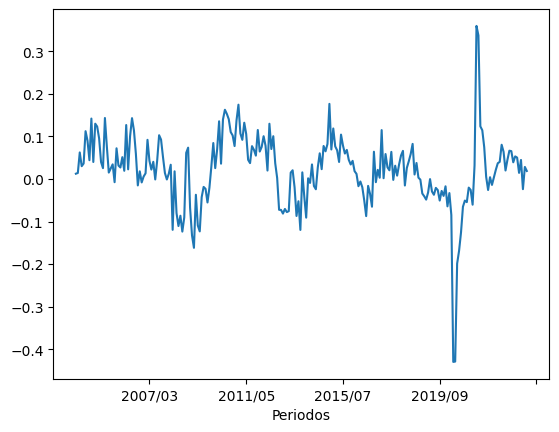

In [264]:
IAQ['diff12'].plot()

In [265]:
adfuller(IAQ['lIndAct'].dropna())[1]

0.269199852269532

In [266]:
adfuller(IAQ['diff12'].dropna())[1]

0.01098300845261186

The pvalue returned by the Dickey-Fuller test for the 12th difference is 0.01098300845261186 and is smaller than 0.05. This means that the Time Series is stationary.

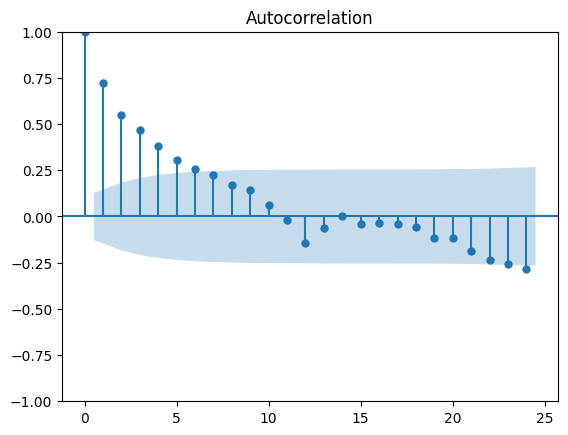

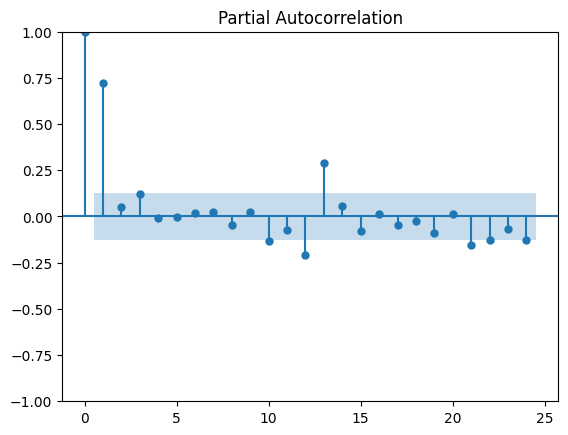

In [267]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(IAQ['diff12'].dropna())
plot_pacf(IAQ['diff12'].dropna())
plt.show()

In [268]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


#order = (p,d,q), seasonal_order= (P,D,Q,s)
# p = 1, because the first LAGs in the PACF display a sharp cutoff
# d = 0, because we are not using the first difference
# q = 0, because the LAGs of the ACF dont display a sharp cutoff or LAG-1 is negative
# P = 0, because we need to check the residuals of a first model to determine the value
# D = 1, because we are using the seasonal difference, in this case the 12th diff
# Q = 0, because we need to check the residuals of a first model to determine the value
# s = 12, because there are 12 observations per year
y = IAQ['lIndAct']
Aorder = (1, 0, 0)
SAorder = (0, 1, 0, 12)
model = SARIMAX(y, order=Aorder, seasonal_order=SAorder, trend='c')
model=model.fit()
model.summary()

d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            lIndAct   No. Observations:                  246
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 331.391
Date:                            Fri, 20 Oct 2023   AIC                           -656.782
Time:                                    22:01:34   BIC                           -646.416
Sample:                                         0   HQIC                          -652.602
                                            - 246                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0059      0.004      1.524      0.127      -0.002       0.013
ar.L1          0.7202      0.034     21.249      0.000       0.654       0.787
sigma2         0.0034      0.000     25.504      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               980.99
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.28
Prob(H) (two-sided):                  0.09   Kurtosis:                        13.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [269]:
model.resid.head(20)

Periodos
2003/01    4.157034
2003/02    4.149586
2003/03    4.097188
2003/04    4.152711
2003/05    4.065398
2003/06    4.061200
2003/07    4.065378
2003/08    4.169367
2003/09    4.315657
2003/10    4.206869
2003/11    4.043884
2003/12    4.083248
2004/01   -0.008596
2004/02   -0.000686
2004/03    0.046296
2004/04   -0.020733
2004/05    0.008837
2004/06    0.080177
2004/07    0.003233
2004/08   -0.026562
dtype: float64

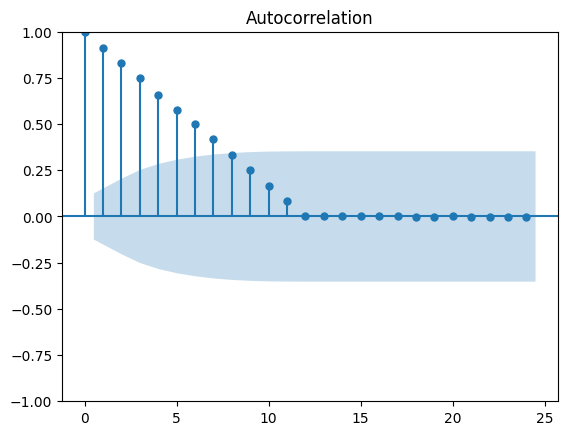

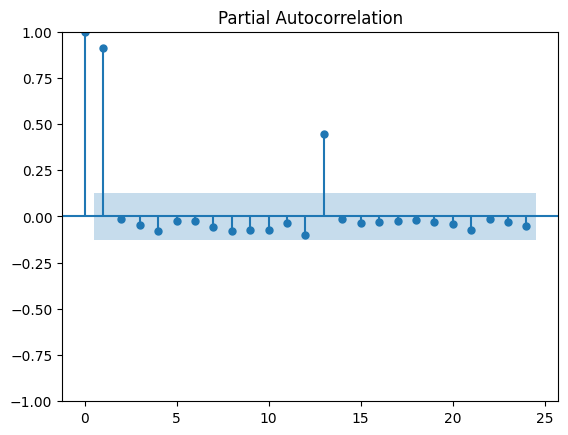

In [270]:
plot_acf(model.resid)
plot_pacf(model.resid)
plt.show()

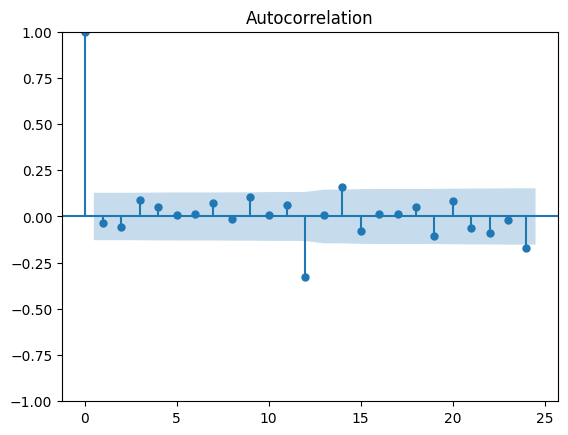

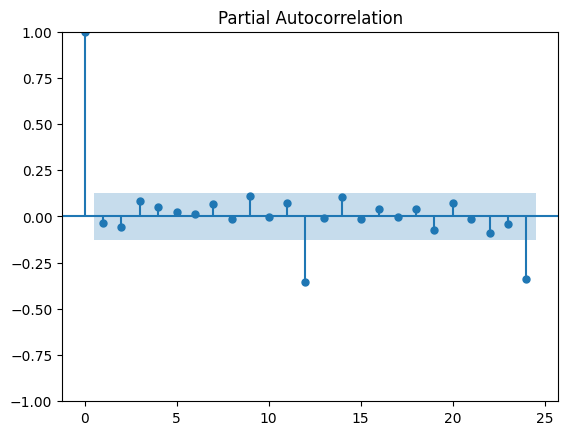

In [271]:
plot_acf(model.resid.iloc[12:])
plot_pacf(model.resid.iloc[12:])
plt.show()

d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


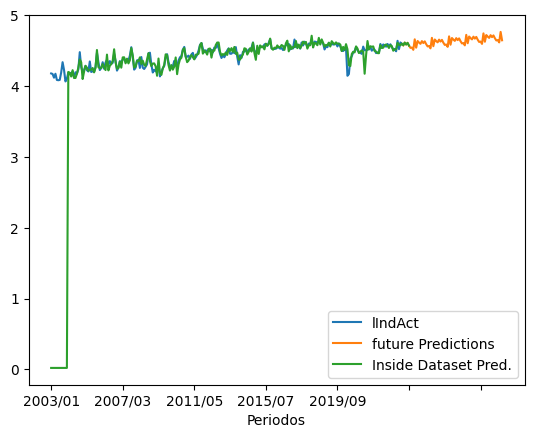

In [272]:
IAQ['lIndAct'].plot()
plt.plot(model.forecast(70),label='future Predictions')
plt.plot(model.predict(start = 0, end = 250), label = 'Inside Dataset Pred.')
plt.legend()

d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
d:\Principal\Workspace\Python\py3114\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


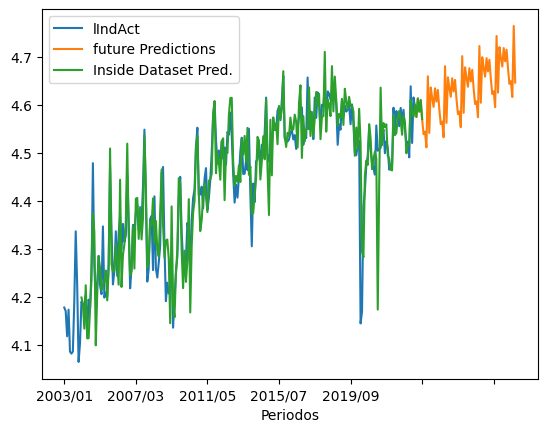

In [273]:
IAQ['lIndAct'].plot()
plt.plot(model.forecast(70),label='future Predictions')
plt.plot(model.predict(start = 12, end = 250), label = 'Inside Dataset Pred.')
plt.legend()